## Portfolio Assignment week 02
## Author: Karina Diaz

This week's focus is on manifold learning and text clustering. As part of the portfolio assignment, you are required to make a contribution to either the manifold learning case or the text clustering case. 

-------

# Clustering text
#### code taking from tutorial_clustering_words.ipynb

See also https://towardsdatascience.com/nmf-a-visual-explainer-and-python-implementation-7ecdd73491f8


This notebook uses a collection of clinical case reports to cluster words by topics using the NMF method. To cluster text we need to preprocess the text first with regular natural language processing cleaning steps such as remove punctuations, stopwords, or other unwanted text. we lower the text and use the lemma to reduce variation of words. This is all done in part A. 

Next we need to prepare the text in a document term matrix so that NMF can perform the calculations. The Document-Term Matrix (DTM) represents the frequency of words (or terms) in a collection of documents. Each row in the matrix represents a document, and each column represents a word in the vocabulary. The value in each cell represents the frequency of the corresponding word in the corresponding document. This is done in part B

Lastly we run the clustering algorithm and visualize the outcome. This is done in part C


## The data 
A collection of 200 clinical case report documents in plain text format are used. The documents are named using PubMed document IDs, and have been edited to include only clinical case report details. The dataset is called "MACCROBAT2020" and is the second release of this dataset, with improvements made to the consistency and format of annotations
https://figshare.com/articles/dataset/MACCROBAT2018/9764942


## Portfolio assignment

You can use this assignment to fill your portfolio.
Read, execute and analyse the code in the notebook. Then *choose one* of the assignments a), b) or c). 

a) read the article Clinical Documents Clustering Based on Medication/Symptom Names Using Multi-View Nonnegative Matrix Factorization. you can find the article <a href = 'https://pubmed.ncbi.nlm.nih.gov/26011887/'> here</a>. Explain the similarities of this notebook and the article. Explain in your own words what need to be added to this notebook to reproduce the article. There is no need to code the solution.

#### **b) Improve the outcome improving the data preprocessing and the hyper parameter configurations. Explain your choices. Your solution should be a coded solution with comments. Are there any other weighting solutions next to TF-IDF?**

c) Provide a text clustering solution with your own data of interest, for instance text you work with in your project. 

Mind you that you are not allowed to copy code solutions without referencing. 

In [1]:
# For dataframe and document manipulation
import glob
import pandas as pd
from pathlib import Path

# For text cleaning
import re
import string

# For text processing
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer

# For modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer

# For plotting
import matplotlib.pyplot as plt

# import nltk
# nltk.download('punkt')
# nltk.download('wordnet')

# Part A: get and clean the text

## Get the data

In [2]:
# Create empty dataframe
df = pd.DataFrame(columns=['docid','text'])

# Get all files ending with .txt
docs = [x for x in glob.glob("./Data/MACCROBAT2020/*.txt")]

# Fill dataframe
for doc in docs:
    txt = Path(doc).read_text()
    df.loc[len(df.index)] = [doc[:-4], txt]

In [3]:
df.head(3)

,docid,text
0,./Data/MACCROBAT2020/18561524,An 18-year-old male was diagnosed with attenti...
1,./Data/MACCROBAT2020/28115731,A 64-year-old female was found lying down afte...
2,./Data/MACCROBAT2020/24898994,A woman in her 60s was found to have screen de...


In [4]:
# Remove the path of the docid
df['docid'].replace(regex={'.*[2][0][2][0]/':''},inplace = True)
df.head()

,docid,text
0,18561524,An 18-year-old male was diagnosed with attenti...
1,28115731,A 64-year-old female was found lying down afte...
2,24898994,A woman in her 60s was found to have screen de...
3,28538413,A 63-year-old male patient without smoking or ...
4,28321073,A 65-year-old man with a 45-year history of ci...


In [5]:
# Set index docid       
df = df.set_index('docid')
df.head(3)

,text
docid,
18561524,An 18-year-old male was diagnosed with attenti...
28115731,A 64-year-old female was found lying down afte...
24898994,A woman in her 60s was found to have screen de...


## Cleaning the text

The code below defines a function called clean_text that takes a text parameter and returns a cleaned version of it. The function first converts the text to lowercase using the `lower()` method. It then removes any text enclosed in square brackets using **regular expressions** and the re.sub() method. Next, it removes any **punctuation** from the text using the `string.punctuation` module and `re.escape()` and `re.sub()` methods. It then removes any words that **contain numbers** using `re.sub()` and a regular expression. Finally, it removes any **read errors** (represented by the � character) using `re.sub()`.

The code then defines a lambda function called cleaned that takes a single parameter `x` and applies the `clean_text` function to it. This lambda function can be used to clean text data in a Pandas dataframe or any other data structure that can take a lambda function

I improved the cleaning, by also removing the new line symbols.

In [6]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, 
    remove punctuation, remove read errors,
    remove words containing numbers and new line simbols'''
    text = text.lower()
    # remove any text enclosed in square brackets
    text = re.sub('\[.*?\]', ' ', text)
    #  removes any punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    # remove words containing numbers
    text = re.sub('\w*\d\w*', ' ', text)
    # removes any read errors
    text = re.sub('�', ' ', text)
    # removes new lines
    text = re.sub('\\n',' ', text)
    
    return text

cleaned = lambda x: clean_text(x)


The function 'nouns' cleans a text and extracts only the nouns from it. It first defines a lambda function called 'is_noun' that checks if a given word is a noun, based on its part of speech (POS) tag. The input text is then tokenized using the `word_tokenize` function from the **nltk** module, which breaks down the text into smaller units called tokens. Tokenization is an important pre-processing step in NLP that helps standardize and prepare text data for further analysis.

The function creates a `WordNetLemmatizer` object from the nltk module to lemmatize each word, which is the process of converting a word to its base or dictionary form. Lemmatization helps to reduce the dimensionality of text data and improve the accuracy of the analysis, especially in cases where words have different inflected forms but share the same root.

The function uses a list comprehension to lemmatize each word in the tokenized text if it is a noun, and stores the resulting list of lemmatized nouns in the 'all_nouns' variable. Finally, the function returns a string containing the joined list of lemmatized nouns.

Note that this function requires the 'nltk' module to be imported and assumes that the 'pos_tag' function from the 'nltk' module is available.

In [7]:
# Noun extract and lemmatize function
def nouns(text):
    '''Given a string of text, tokenize the text 
    and pull out only the nouns.'''
    # create mask to isolate words that are nouns
    is_noun = lambda pos: pos[:2] == 'NN'
    # store function to split string of words 
    # into a list of words (tokens)
    tokenized = word_tokenize(text)
    # store function to lemmatize each word
    wordnet_lemmatizer = WordNetLemmatizer()
    # use list comprehension to lemmatize all words 
    # and create a list of all nouns
    all_nouns = [wordnet_lemmatizer.lemmatize(word) \
    for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    
    #return string of joined list of nouns
    return ' '.join(all_nouns)

I also decided to extract the verbs and adjectives of the documents to have a better understanding of the contents of these. Therefore I created two different functions to do so.

In [8]:
# Verb extract and lemmatize function
def verbs(text):
    '''Given a string of text, tokenize the text 
    and pull out only the verbs.'''
    # create mask to isolate words that are verbs
    is_verb = lambda pos: pos[:2] == 'VB'
    # store function to split string of words 
    # into a list of words (tokens)
    tokenized = word_tokenize(text)
    # store function to lemmatize each word
    wordnet_lemmatizer = WordNetLemmatizer()
    # use list comprehension to lemmatize all words 
    # and create a list of all verbs
    all_verbs = [wordnet_lemmatizer.lemmatize(word) \
    for (word, pos) in pos_tag(tokenized) if is_verb(pos)] 
    
    #return string of joined list of verbs
    return ' '.join(all_verbs)

In [9]:
# Adjective extract and lemmatize function
def adjectives(text):
    '''Given a string of text, tokenize the text 
    and pull out only the adjectives.'''
    # create mask to isolate words that are nouns
    is_adjective = lambda pos: pos[:2] == 'JJ'
    # store function to split string of words 
    # into a list of words (tokens)
    tokenized = word_tokenize(text)
    # store function to lemmatize each word
    wordnet_lemmatizer = WordNetLemmatizer()
    # use list comprehension to lemmatize all words 
    # and create a list of all adjectives
    all_adjectives = [wordnet_lemmatizer.lemmatize(word) \
    for (word, pos) in pos_tag(tokenized) if is_adjective(pos)] 
    
    #return string of joined list of adjectives
    return ' '.join(all_adjectives)

In [10]:
# Clean Text
df["text"] = df["text"].apply(cleaned)

In [11]:
# Look for nouns
data_nouns = pd.DataFrame(df["text"].apply(nouns))
# Visually Inspect
data_nouns.head(3)

,text
docid,
18561524,year male attention deficit hyperactivity diso...
28115731,year female hour binge drinking emergency depa...
24898994,woman screen breast carcinoma breast ductal ca...


In [12]:
# Look for verbs
data_verbs = pd.DataFrame(df["text"].apply(verbs))
# Visually Inspect
data_verbs.head(3)

,text
docid,
18561524,wa diagnosed wa overweight wa started mg wa ad...
28115731,wa found lying wa taken outlying transferred h...
24898994,wa found have detected staging imaging mastect...


In [13]:
# Look for adjectives
data_adjectives = pd.DataFrame(df["text"].apply(adjectives))
# Visually Inspect
data_adjectives.head(3)

,text
docid,
18561524,old mg local severe mmhg arterial − reactive c...
28115731,old – mental further past congestive past hg a...
24898994,invasive lobular right invasive special initia...


# Part B: The Document-Term Matrix (DTM)

To perform analyses we need to create a Document-Term Maxtrix. 
The Document-Term Matrix (DTM) represents the frequency of words (or terms) in a collection of documents. Each row in the matrix represents a document, and each column represents a word in the vocabulary. The value in each cell represents the frequency of the corresponding word in the corresponding document.

In specific case below, the DTM has been created using only the nouns extracted from the original text, and has been transformed using the TF-IDF (Term Frequency-Inverse Document Frequency) weighting scheme. The TF-IDF scheme assigns weights to words based on how often they appear in a document relative to how often they appear in the entire corpus. Words that appear frequently in a document but infrequently in the corpus are given higher weights, as they are considered to be more important for distinguishing that document from others in the corpus. This weighting scheme is commonly used in text mining and information retrieval to identify key terms or topics in a collection of documents.

The resulting DTM can be used for various purposes such as topic modeling, clustering, classification, and visualization of text data.

In [14]:
def tfid_vect(data_postag):
    '''Create a document-term matrix (V) with the 
    postag to analyse using TfidfVectorizer model
    Returns:
    tv_postag = TF-IDF Vectorizer
    data_dtm_postag_tv = Document Term Matrix  (V matrix) as a dataframe
    '''  
    # Store TF-IDF Vectorizer
    tv_postag = TfidfVectorizer(stop_words=text.ENGLISH_STOP_WORDS, 
                              ngram_range = (1,1),
                              max_df = .8,
                              min_df = .01)
    
    # Fit and Transform speech noun text to a TF-IDF Doc-Term Matrix
    data_tv_postag = tv_postag.fit_transform(data_postag.text)

    # Create data-frame of Doc-Term Matrix(V) with postag as column names
    data_dtm_postag = pd.DataFrame(data_tv_postag.toarray(), 
                                 columns=tv_postag.get_feature_names_out())
    # Set the postag as index 
    data_dtm_postag.index = df.index
    # Visually inspect Document Term Matrix (V)
    print('Doc-Term Matrix (V)')
    print(data_dtm_postag.head(3))

    return tv_postag, data_dtm_postag

Applying the TfidfVectorizer to obtain the V matrix of the nouns, adjetives and verbs: 

In [15]:
print('TfidfVectorizer - nouns') 
# TF-IDF Vectorizer noun,  Document Term Matrix noun 
tv_noun, data_dtm_tv_noun = tfid_vect(data_postag = data_nouns)

TfidfVectorizer - nouns
Doc-Term Matrix (V)
          abdomen  ablation  abnormality  abscess  absence  absent  abuse  \
docid                                                                       
18561524      0.0       0.0          0.0      0.0      0.0     0.0    0.0   
28115731      0.0       0.0          0.0      0.0      0.0     0.0    0.0   
24898994      0.0       0.0          0.0      0.0      0.0     0.0    0.0   

          access  accompanying  accordance  ...      york   yr  zhejiang  \
docid                                       ...                            
18561524     0.0           0.0         0.0  ...  0.091488  0.0       0.0   
28115731     0.0           0.0         0.0  ...  0.000000  0.0       0.0   
24898994     0.0           0.0         0.0  ...  0.000000  0.0       0.0   

          zinc  zone   µg  µmol   μg   μl  μmol  
docid                                            
18561524   0.0   0.0  0.0   0.0  0.0  0.0   0.0  
28115731   0.0   0.0  0.0   0.0  0.0  0

In [16]:
print('TfidfVectorizer - verbs') 
# TF-IDF Vectorizer verb,  Document Term Matrix verb
tv_verb, data_dtm_tv_verb = tfid_vect(data_postag = data_verbs)

TfidfVectorizer - verbs
Doc-Term Matrix (V)
          absorbed  accompanied  accompanying  according  acenocumarol  \
docid                                                                    
18561524       0.0          0.0           0.0        0.0           0.0   
28115731       0.0          0.0           0.0        0.0           0.0   
24898994       0.0          0.0           0.0        0.0           0.0   

          achieved  acquired  activated  acute  adapt  ...  withdrawn  worsen  \
docid                                                  ...                      
18561524       0.0       0.0        0.0    0.0    0.0  ...        0.0     0.0   
28115731       0.0       0.0        0.0    0.0    0.0  ...        0.0     0.0   
24898994       0.0       0.0        0.0    0.0    0.0  ...        0.0     0.0   

          worsened  worsening  written  yielded   µg   µl   μm      μmol  
docid                                                                     
18561524  0.000000        0.0

In [17]:
print('TfidfVectorizer - adjectives') 
# TF-IDF Vectorizer noun,  Document Term Matrix noun
tv_adjective, data_dtm_tv_adjective = tfid_vect(data_postag = data_adjectives)

TfidfVectorizer - adjectives
Doc-Term Matrix (V)
          abbreviated  abdominal  able  abnormal  absent  abundant  \
docid                                                                
18561524          0.0        0.0   0.0  0.000000     0.0  0.000000   
28115731          0.0        0.0   0.0  0.107206     0.0  0.000000   
24898994          0.0        0.0   0.0  0.095113     0.0  0.136097   

          acceptable  accessory  accurate  acid  ...  widespread  worse  year  \
docid                                            ...                            
18561524         0.0        0.0       0.0   0.0  ...         0.0    0.0   0.0   
28115731         0.0        0.0       0.0   0.0  ...         0.0    0.0   0.0   
24898994         0.0        0.0       0.0   0.0  ...         0.0    0.0   0.0   

          yellowish  young  younger  zoledronic   μg   μl  μmol  
docid                                                            
18561524        0.0    0.0      0.0         0.0  0.0  0.0   0.

## Other weighting solutions: 
#### **A) CountVectorizer**

Converts a collection of text documents to a *matrix of token counts.* That is, text is converted to numerical data, or counts. **Implements both *tokenization* and *occurrence counting* in a single class**. Therefore, a matrix is created with different columns, each representing a word present on the text. In each row the words are represented by numbers depending on the number of times that specific word appears on the text.  

This transformation is made so that the data can be read and use by machine learning arlgorithms to apply different models.  

The parameter `stop_words` defines which words are going to be ignore beacuse they are uniformative for the text mining analysis. In this case all the english words. 

`ngram_range` are the *lower* and *upper* *boundary* of the range *of n-values* for different word n-grams or char n-grams to be extracted. (1, 1) means only unigrams that is, single words. (2, 2) means only bigrams, that is a two-word sequence of words. (1, 2) means unigrams and bigrams.
In this case only unigrams are going to be used, as we are more interested in single words (nouns, verbs and adjectives)

`max_df` is useful when building the vocabulary. This parameter *ignore terms* that have a *document frequency* strictly *higher* than the given threshold (*0.8* in this case). 

`min_df` is similar. This parameter *ignore terms* that have a *document frequency* strictly *lower* than the given threshold (*0.01* in this case). This value is also called *cut-off* in the literature. 

These parameters used are the same used in the TfidfVectorizer model. 


In [18]:
def count_vect(data_postag):
    '''Create a document-term matrix (V) with the 
    postag to analyse using CountVectorizer model
    Returns:
    cv_postag = CountVectorizer
    data_dtm_postag = Document Term Matrix (V matrix) as a dataframe
    '''  
    # Store CountVectorizer
    cv_postag = CountVectorizer(stop_words=text.ENGLISH_STOP_WORDS,
                                ngram_range = (1,1),
                                max_df = 0.8,
                                min_df = 0.01)
    
    # Fit and Transform speech noun text to a CountVectorizer Doc-Term Matrix
    data_cv_postag = cv_postag.fit_transform(data_postag.text)

    # Create data-frame of Doc-Term Matrix(V) with postag as column names
    data_dtm_postag = pd.DataFrame(data_cv_postag.toarray(), 
                                 columns=cv_postag.get_feature_names_out())
    # Set the postag as index 
    data_dtm_postag.index = df.index
    # Visually inspect Document Term Matrix (V)
    print('Doc-Term Matrix (V)')
    print(data_dtm_postag.head(3))

    return cv_postag, data_dtm_postag


In [19]:
# Apply count_vect function
print('CountVectorizer - nouns') 
# CountVectorizer noun,  Document Term Matrix noun 
cv_noun, data_dtm_cv_noun = count_vect(data_postag = data_nouns)

CountVectorizer - nouns
Doc-Term Matrix (V)
          abdomen  ablation  abnormality  abscess  absence  absent  abuse  \
docid                                                                       
18561524        0         0            0        0        0       0      0   
28115731        0         0            0        0        0       0      0   
24898994        0         0            0        0        0       0      0   

          access  accompanying  accordance  ...  york  yr  zhejiang  zinc  \
docid                                       ...                             
18561524       0             0           0  ...     1   0         0     0   
28115731       0             0           0  ...     0   0         0     0   
24898994       0             0           0  ...     0   0         0     0   

          zone  µg  µmol  μg  μl  μmol  
docid                                   
18561524     0   0     0   0   0     0  
28115731     0   0     0   0   0     0  
24898994     0   0  

In [20]:
print('CountVectorizer - verbs') 
# CountVectorizer verb,  Document Term Matrix verb
cv_verb, data_dtm_cv_verb = count_vect(data_postag = data_verbs)

CountVectorizer - verbs
Doc-Term Matrix (V)
          absorbed  accompanied  accompanying  according  acenocumarol  \
docid                                                                    
18561524         0            0             0          0             0   
28115731         0            0             0          0             0   
24898994         0            0             0          0             0   

          achieved  acquired  activated  acute  adapt  ...  withdrawn  worsen  \
docid                                                  ...                      
18561524         0         0          0      0      0  ...          0       0   
28115731         0         0          0      0      0  ...          0       0   
24898994         0         0          0      0      0  ...          0       0   

          worsened  worsening  written  yielded  µg  µl  μm  μmol  
docid                                                              
18561524         0          0        0     

In [21]:
print('CountVectorizer - adjectives') 
# CountVectorizer noun,  Document Term Matrix noun
cv_adjective, data_dtm_cv_adjective = count_vect(data_postag = data_adjectives)

CountVectorizer - adjectives
Doc-Term Matrix (V)
          abbreviated  abdominal  able  abnormal  absent  abundant  \
docid                                                                
18561524            0          0     0         0       0         0   
28115731            0          0     0         1       0         0   
24898994            0          0     0         1       0         1   

          acceptable  accessory  accurate  acid  ...  widespread  worse  year  \
docid                                            ...                            
18561524           0          0         0     0  ...           0      0     0   
28115731           0          0         0     0  ...           0      0     0   
24898994           0          0         0     0  ...           0      0     0   

          yellowish  young  younger  zoledronic  μg  μl  μmol  
docid                                                          
18561524          0      0        0           0   0   0     0  
28

As we can see we obtain counts(int) rather than float weights like in the TfidfVectorizer model.

#### **B) HashingVectorizer**
Converts a collection of *text* documents to a matrix of *token occurrences*.  
Here a hashing techinique is combined with the text preprocessing and tokenization features of the CountVectorizer.

The parameter `stop_words` defines which words are going to be ignore beacuse they are uniformative for the text mining analysis. In this case all the english words. 

`ngram_range` are the *lower* and *upper* *boundary* of the range *of n-values* for different word n-grams or char n-grams to be extracted. (1, 1) means only unigrams that is, single words. (2, 2) means only bigrams, that is a two-word sequence of words. (1, 2) means unigrams and bigrams.
In this case only unigrams are going to be used, as we are more interested in single words (nouns, verbs and adjectives). 

These are the only parameters applied, all the others are the default ones, as i read them and do not seem to be relevant in this case.



In [22]:
def hash_vect(data_postag):
    '''Create a document-term matrix (V) with the 
    postag to analyse using HashingVectorizer model
    Returns:
    hv_postag = HashingVectorizer
    data_dtm_postag = Document Term Matrix  (V matrix) as a dataframe
    '''  
    # Store HashingVectorizer
    hv_postag= HashingVectorizer(stop_words=text.ENGLISH_STOP_WORDS,
                                 ngram_range = (1,1))
    
    # Fit and Transform speech noun text to a TF-IDF Doc-Term Matrix
    data_hv_postag = hv_postag.fit_transform(data_postag.text)

    # Create data-frame of Doc-Term Matrix(V) with postag as column names
    data_dtm_postag = pd.DataFrame(data_hv_postag.toarray())
    # Set the postag as index 
    data_dtm_postag.index = df.index
    # Visually inspect Document Term Matrix (V)
    print('Doc-Term Matrix (V)')
    print(data_dtm_postag.head(3))

    return hv_postag, data_dtm_postag

In [23]:
# Apply hash_vect function
print('HashingVectorizer - nouns') 
# HashingVectorizer noun,  Document Term Matrix noun 
hv_noun, data_dtm_hv_noun = hash_vect(data_postag = data_nouns)


HashingVectorizer - nouns
Doc-Term Matrix (V)
          0        1        2        3        4        5        6        \
docid                                                                     
18561524      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
28115731      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
24898994      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

          7        8        9        ...  1048566  1048567  1048568  1048569  \
docid                                ...                                       
18561524      0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
28115731      0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
24898994      0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   

          1048570  1048571  1048572  1048573  1048574  1048575  
docid                                                           
18561524      0.0      0.0      0.0      0.0   

In [24]:
print('HashingVectorizer - verbs') 
# HashingVectorizer verb,  Document Term Matrix verb
hv_verb, data_dtm_hv_verb = hash_vect(data_postag = data_verbs)


HashingVectorizer - verbs
Doc-Term Matrix (V)
          0        1        2        3        4        5        6        \
docid                                                                     
18561524      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
28115731      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
24898994      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

          7        8        9        ...  1048566  1048567  1048568  1048569  \
docid                                ...                                       
18561524      0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
28115731      0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
24898994      0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   

          1048570  1048571  1048572  1048573  1048574  1048575  
docid                                                           
18561524      0.0      0.0      0.0      0.0   

In [25]:
print('HashingVectorizer - adjectives') 
# HashingVectorizer noun,  Document Term Matrix noun
hv_adjective, data_dtm_hv_adjective = hash_vect(data_postag = data_adjectives)

HashingVectorizer - adjectives
Doc-Term Matrix (V)
          0        1        2        3        4        5        6        \
docid                                                                     
18561524      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
28115731      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
24898994      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

          7        8        9        ...  1048566  1048567  1048568  1048569  \
docid                                ...                                       
18561524      0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
28115731      0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
24898994      0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   

          1048570  1048571  1048572  1048573  1048574  1048575  
docid                                                           
18561524      0.0      0.0      0.0      0

As we can see we obtain float weights like in the TfidfVectorizer model.
The difference is that this model does not allow you to access the original string representation of the features, because of the one-way nature of the hash function that performs the mapping. As we can see in the column names of the Document Term Matrices (V). So I do not continue with the ‘Non-negative Matrix-Factorization’ method.

HashingVectorizer overcomes the problem that only hashin has about memory constrains. With this method collisions are not longer created, but this comes at the expense of a much larger dimensionality of the output space. As we see in the size difference of the other models when analysing the nouns, verbs and adjectives:   

* Nouns
    * TfidfVectorizer - 1959 columns
    * CountVectorizer - 1959 columns
    * HashingVectorizer - 1048576 columns

* Verbs
    * TfidfVectorizer - 1959 columns
    * CountVectorizer -  719 columns
    * HashingVectorizer - 1048576 columns

* Adjectives
    * TfidfVectorizer - 1959 columns
    * CountVectorizer -  719 columns
    * HashingVectorizer - 1048576 columns

The size of TfidfVectorizer and CountVectorizer are the same, and the same parameters were applied. So I continue analysing and comparing both of them in the following steps.


# Part C: Run the NMF

This code below performs Non-negative Matrix Factorization (NMF) on the Document Term Matrix (DTM) with only nouns. NMF is a dimensionality reduction technique that decomposes a matrix into two matrices: a **document-topic matrix (W)** and a **topic-term matrix (H)**.

The code first creates an NMF model with 5 topics. The model is then fit to the DTM with the fit_transform() method, which returns the document-topic matrix (W).

The `display_topics()` function is called to extract the top words from the topic-term matrix (H) using the feature names from the TF-IDF vectorizer. 

The resulting output will show the top n words for each of the n topics learned by the NMF model.

In [26]:
def display_topics(model, feature_names, num_top_words, topic_names=None):
    '''Given an NMF model, feature_names, and number of top words, print 
       topic number and its top feature names, up to specified number of top words.'''
    # iterate through topics in topic-term matrix, 'H' aka
    # model.components_
    for ix, topic in enumerate(model.components_):
        #print topic, topic number, and top words
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i] \
             for i in topic.argsort()[:-num_top_words - 1:-1]]))
            # numpy.argsort - Returns the indices that would sort an array

NMF -> Latent Semantic Analysis with the ‘Non-negative Matrix-Factorization’ method 

NMF finds non-negative matrices (W, H) whose product approximates the non-negative matrix V. 

### *V ~ W x H*

* **V -> Visible variables** (Frequency of *terms* in a given *document*).
    * Rows - Documents.
    * Columns - Terms. 
* **W -> Weights** (Unnormalized probabilty of *topics* in a given *document*).
    * Rows - Documents.
    * Columns - Topics / semantic features.
* **H -> Hidden variables** (*Term* frequencies in a given *topic* or semantic feature).
    * Rows - Topics / semantic features.
    * Columns - Visible variables / terms.


In this case this factorization is used for topic extraction, but could also be use for dimensionality reduction or source separation.

The maximum number of iterations was defined as 400, rather than the default (200). Increasing this number improve the convergence of the model and gets a better stimation.

In [27]:
def nmfmodel(n_comp, data):
    '''Apply the NMF model to create the W and H matrix and display topics 
    created.
    Arguments:
        data = Document Term Matrix 'V'
        n_comp = number of topics to display
    Returns:
        nmf_model = information after applied the NMF model
    '''
    # Learn an NMF model for given Document Term Matrix 'V' 
    nmf_model = NMF(n_components = n_comp, max_iter = 400)

    # Extract the document-topic matrix 'W'
    doc_topic = nmf_model.fit_transform(data)

    # # Extract top words from the topic-term matrix 'H' (# model.components_)
    # display_topics(model=nmf_model, 
    #             feature_names=tv_noun.get_feature_names_out(),
    #             num_top_words=10)
    
    return nmf_model


TfidfVectorizer

In [28]:
# TfidfVectorizer - NMF - nouns
nmf_model_noun_tv = nmfmodel(n_comp=5, data = data_dtm_tv_noun)
# TfidfVectorizer - NMF - verbs
nmf_model_verb_tv = nmfmodel(n_comp=5, data = data_dtm_tv_verb)
# TfidfVectorizer - NMF - adjetives
nmf_model_adjective_tv = nmfmodel(n_comp=5, data = data_dtm_tv_adjective)

CountVectorizer

In [29]:
# CountVectorizer  - NMF - nouns
nmf_model_noun_cv = nmfmodel(n_comp=5, data = data_dtm_cv_noun)
# CountVectorizer  - NMF - verbs
nmf_model_verb_cv = nmfmodel(n_comp=5, data = data_dtm_cv_verb)
# CountVectorizer  - NMF - adjetives
nmf_model_adjective_cv = nmfmodel(n_comp=5, data = data_dtm_cv_adjective)

### Plotting the topics
Plot of topics, each represented as bar plot using top few words based on weights.



In [30]:

def plot_top_words(model, feature_names, num_top_words, title):
    ''' Code modified from
        https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html
        Author: Olivier Grisel <olivier.grisel@ensta.org>
        Lars Buitinck
        Chyi-Kwei Yau <chyikwei.yau@gmail.com>
        License: BSD 3 clause'''
    
    fig, axes = plt.subplots(1, 5, figsize=(50, 12), sharex=True)
    axes = axes.flatten()
    # iterate through topics in topic-term matrix, 'H' aka
    # model.components_
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -num_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


Top 'n words' for each of the 'n topics' learned by the NMF model.  
The topics should be infered from the highest word frequencies per topic.

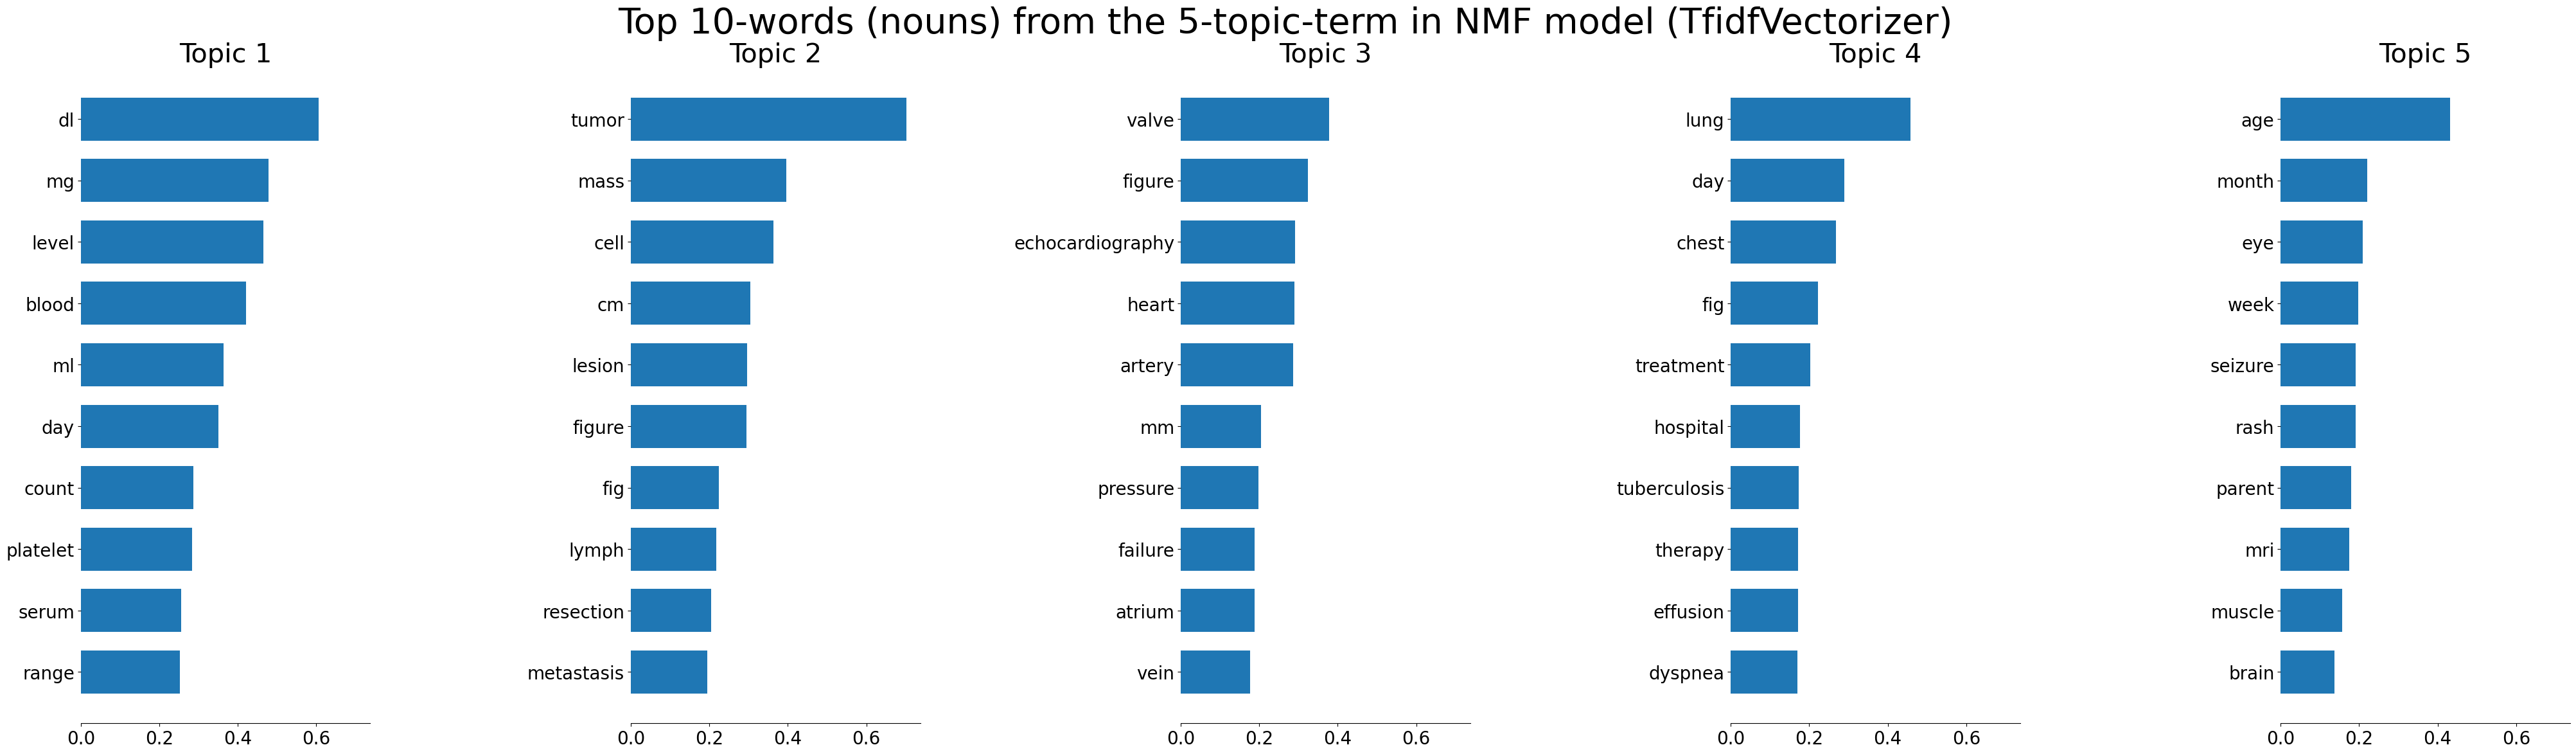

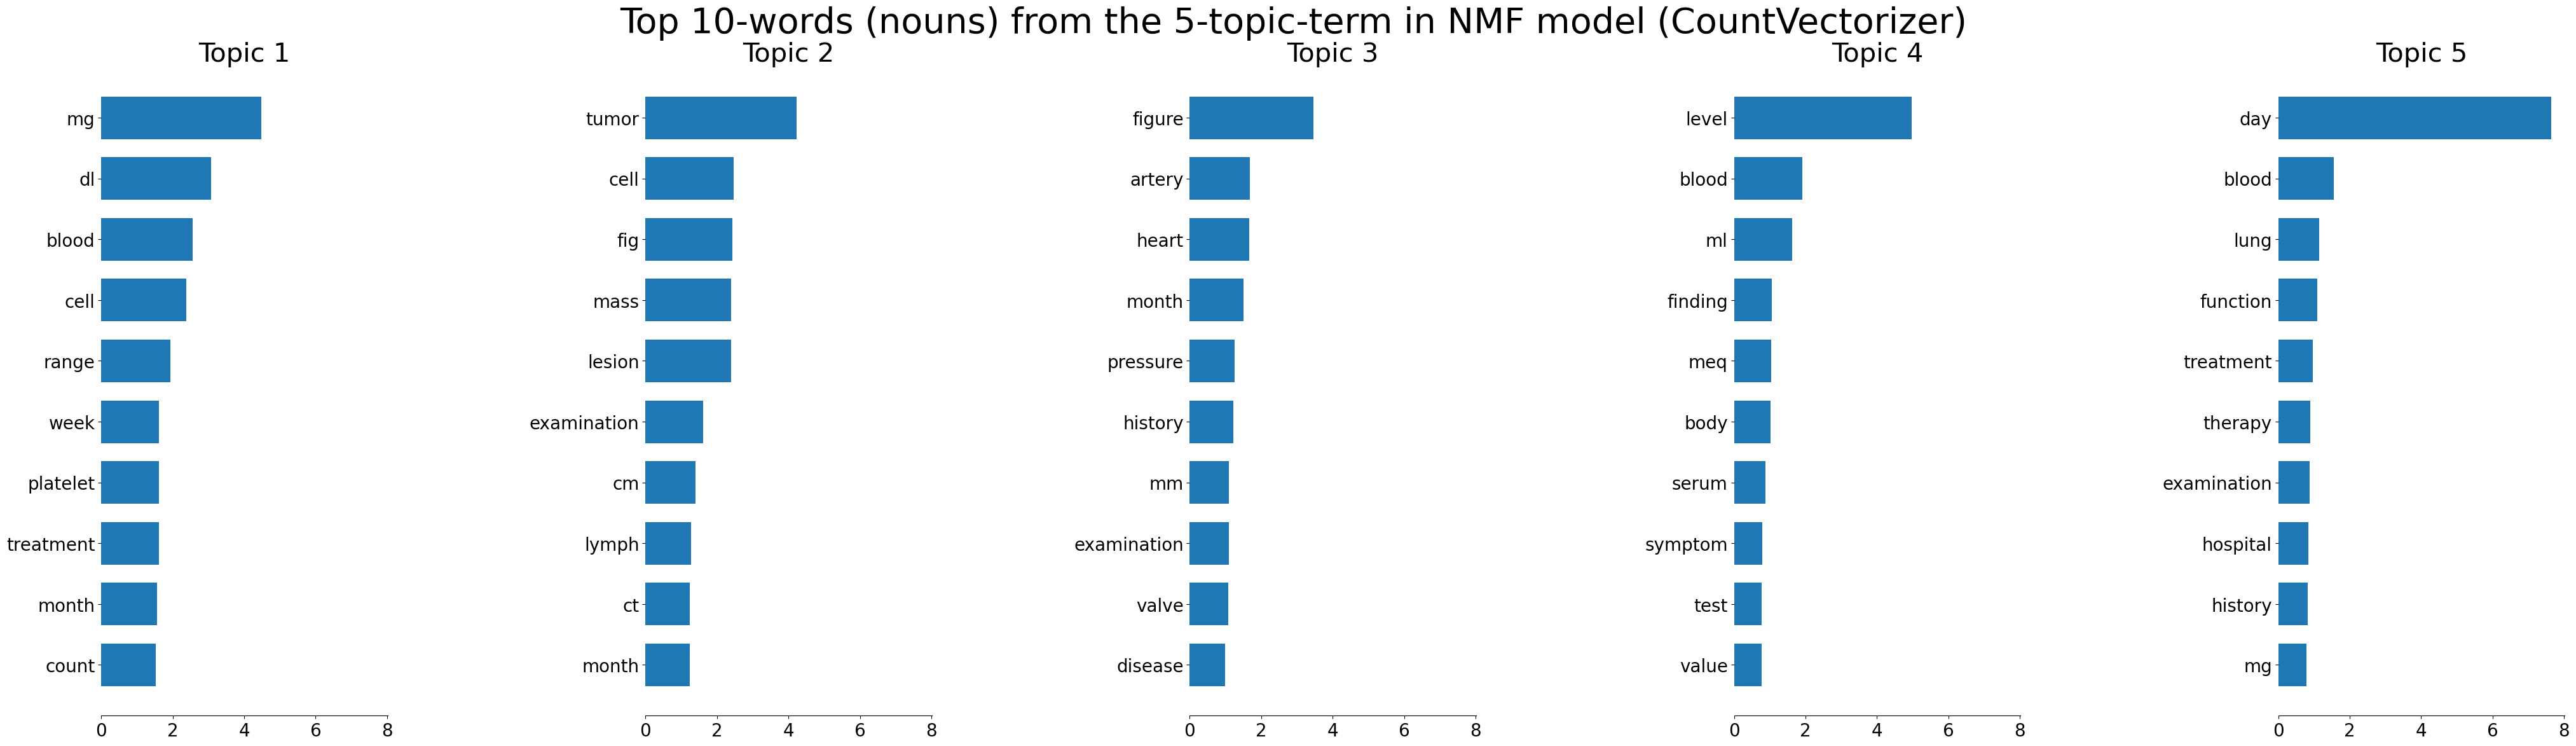

In [31]:
# TfidfVectorizer - NMF - Nouns
plot_top_words(model = nmf_model_noun_tv,
               feature_names = tv_noun.get_feature_names_out(),
               num_top_words = 10,
               title = 'Top 10-words (nouns) from the 5-topic-term in NMF model (TfidfVectorizer)')

# CountVectorizer - NMF - Nouns
plot_top_words(model = nmf_model_noun_cv,
               feature_names = cv_noun.get_feature_names_out(),
               num_top_words = 10,
               title = 'Top 10-words (nouns) from the 5-topic-term in NMF model (CountVectorizer)')

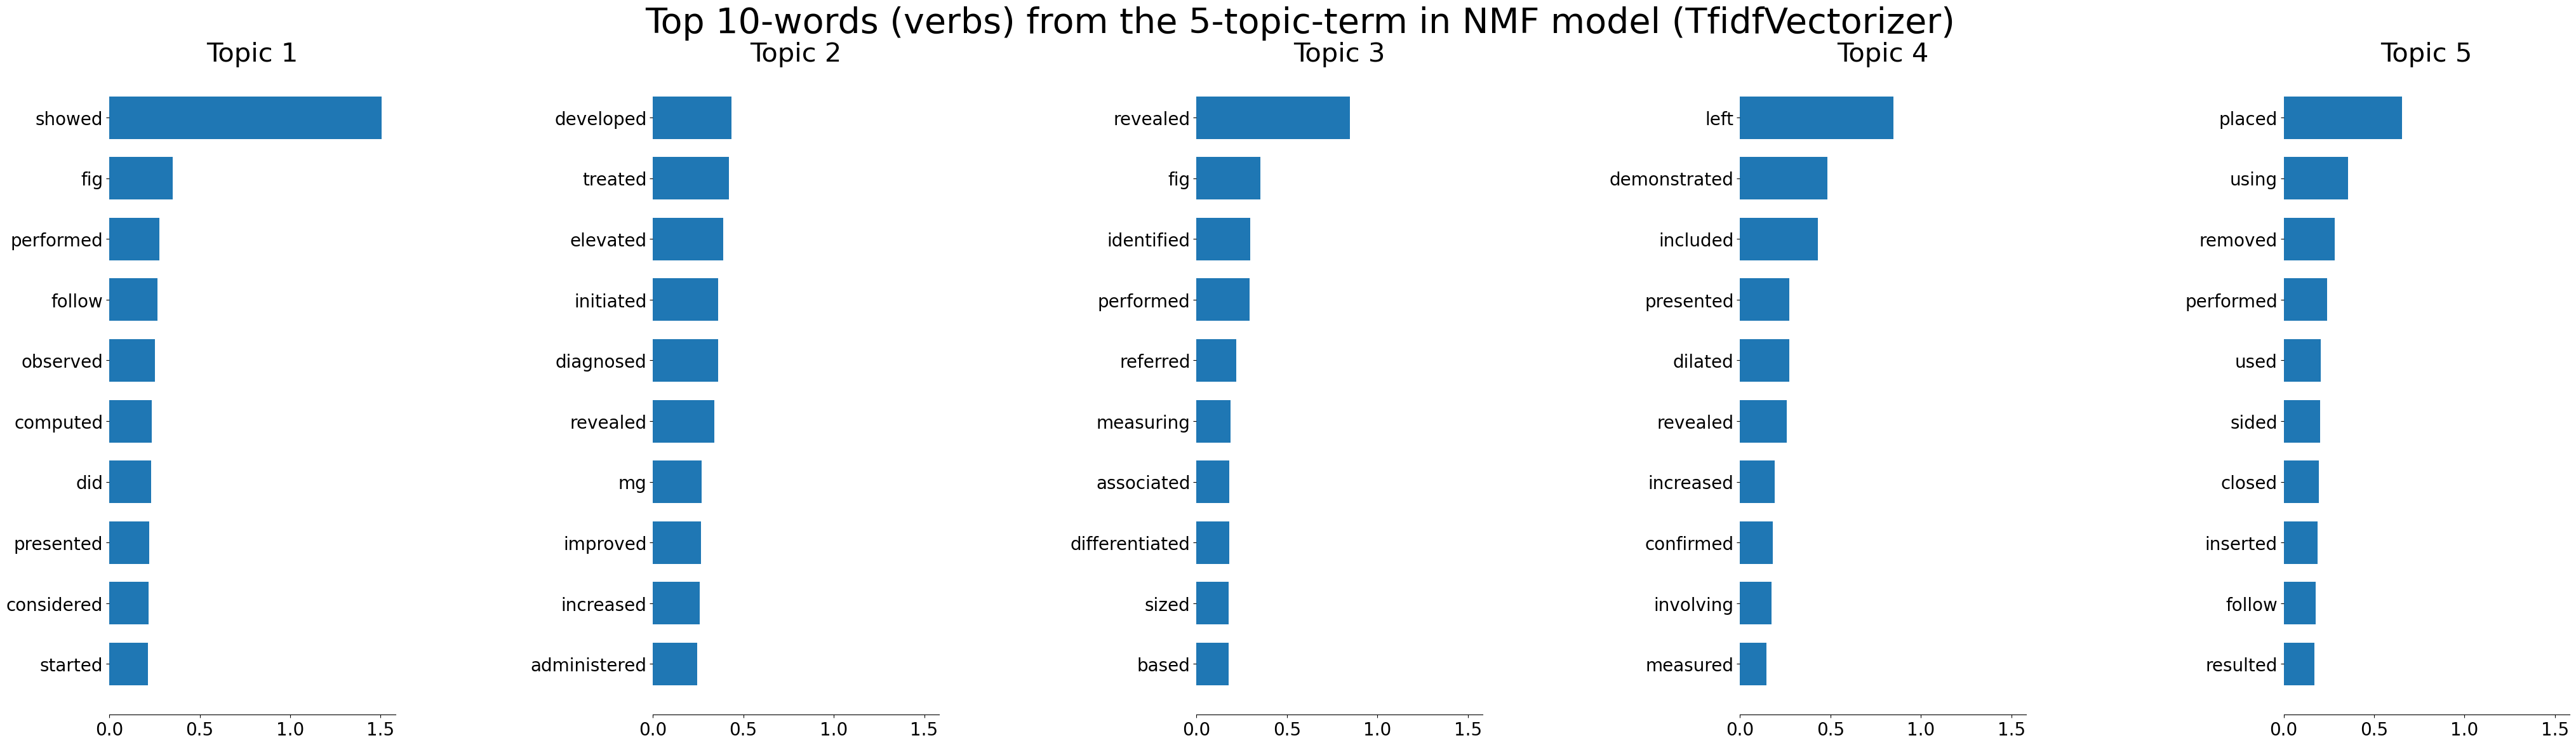

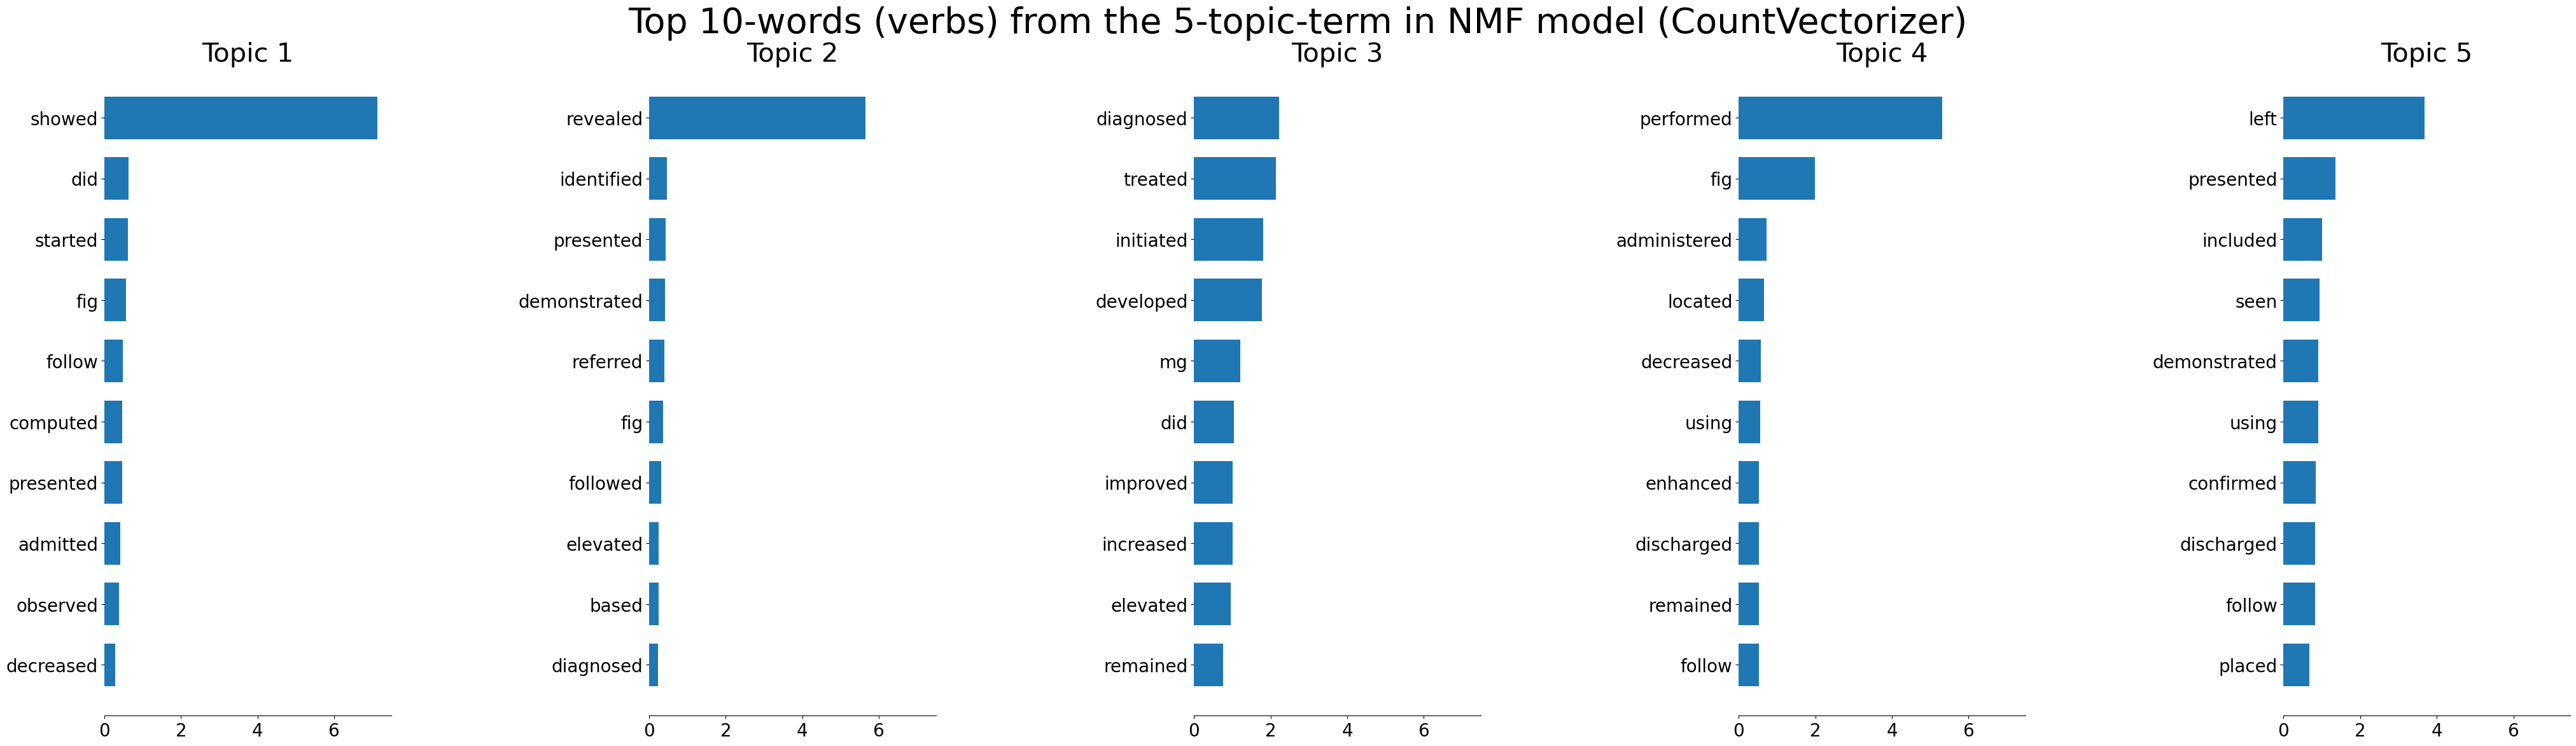

In [32]:
# TfidfVectorizer - NMF - Verbs
plot_top_words(model = nmf_model_verb_tv,
               feature_names = tv_verb.get_feature_names_out(),
               num_top_words = 10,
               title = 'Top 10-words (verbs) from the 5-topic-term in NMF model (TfidfVectorizer)')

# CountVectorizer - NMF - Verbs
plot_top_words(model = nmf_model_verb_cv,
               feature_names = cv_verb.get_feature_names_out(),
               num_top_words = 10,
               title = 'Top 10-words (verbs) from the 5-topic-term in NMF model (CountVectorizer)')

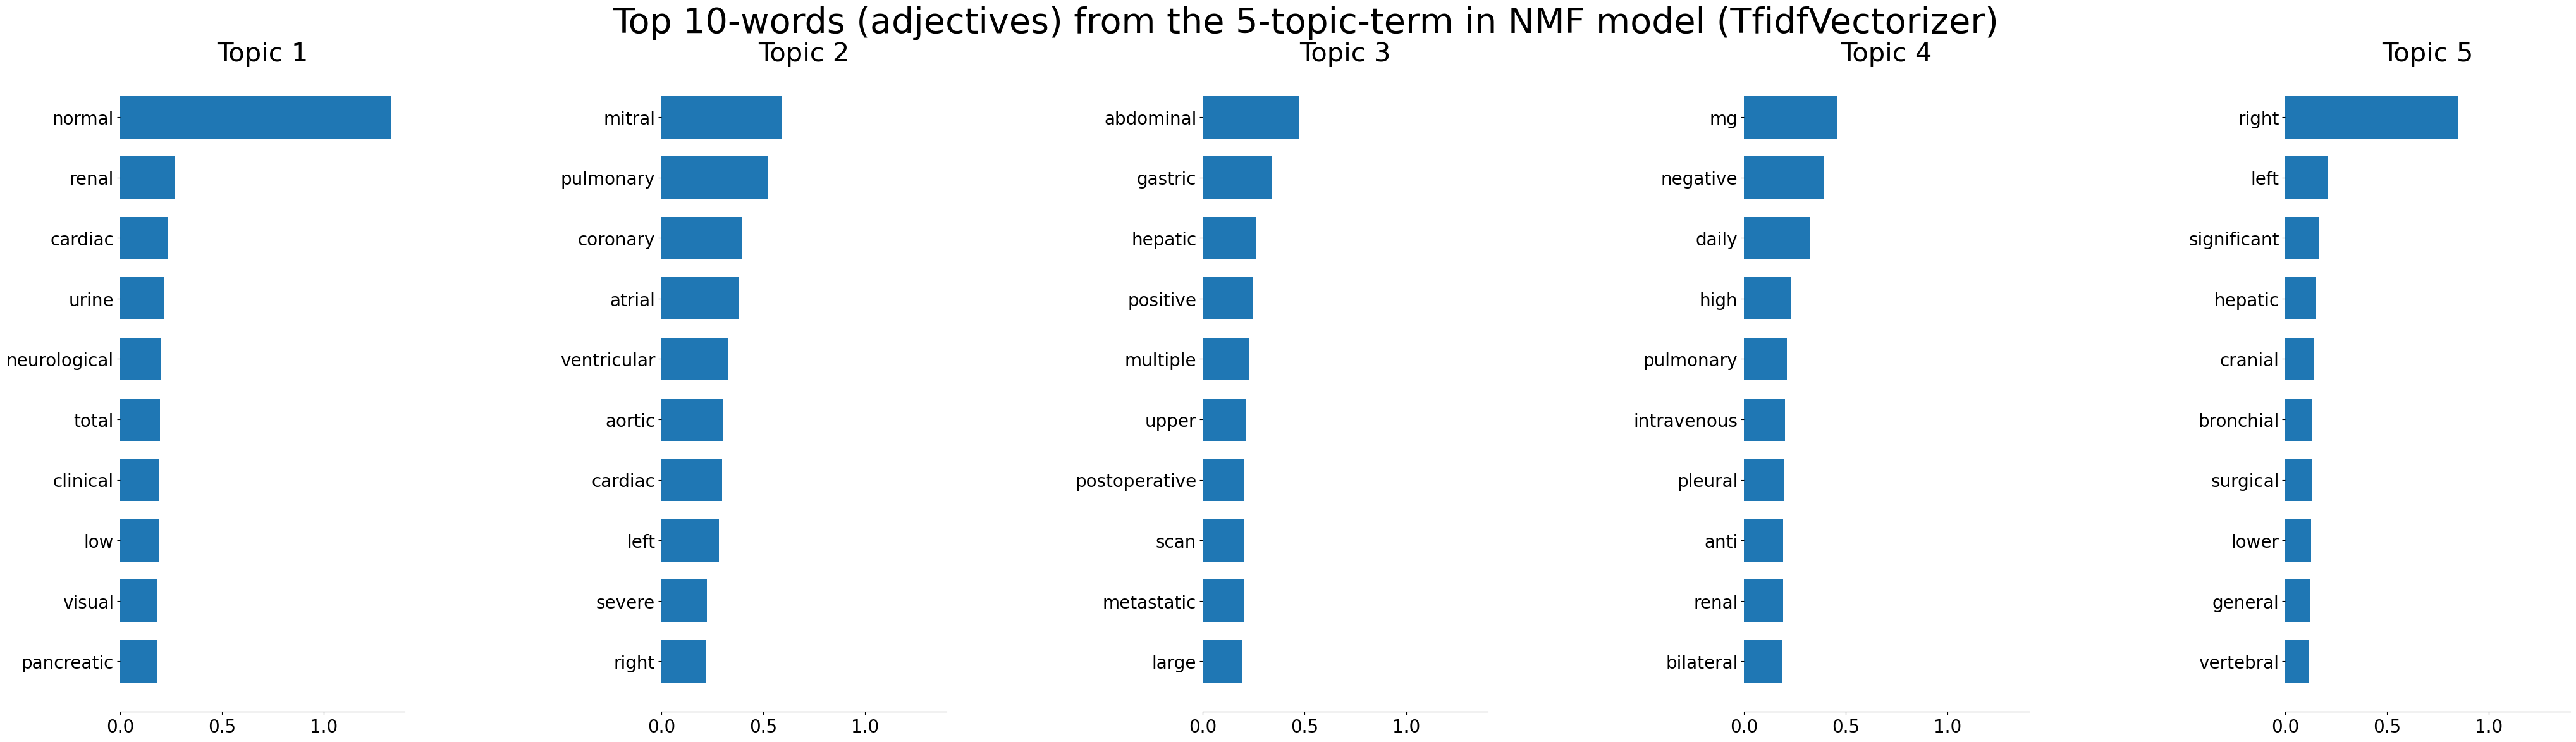

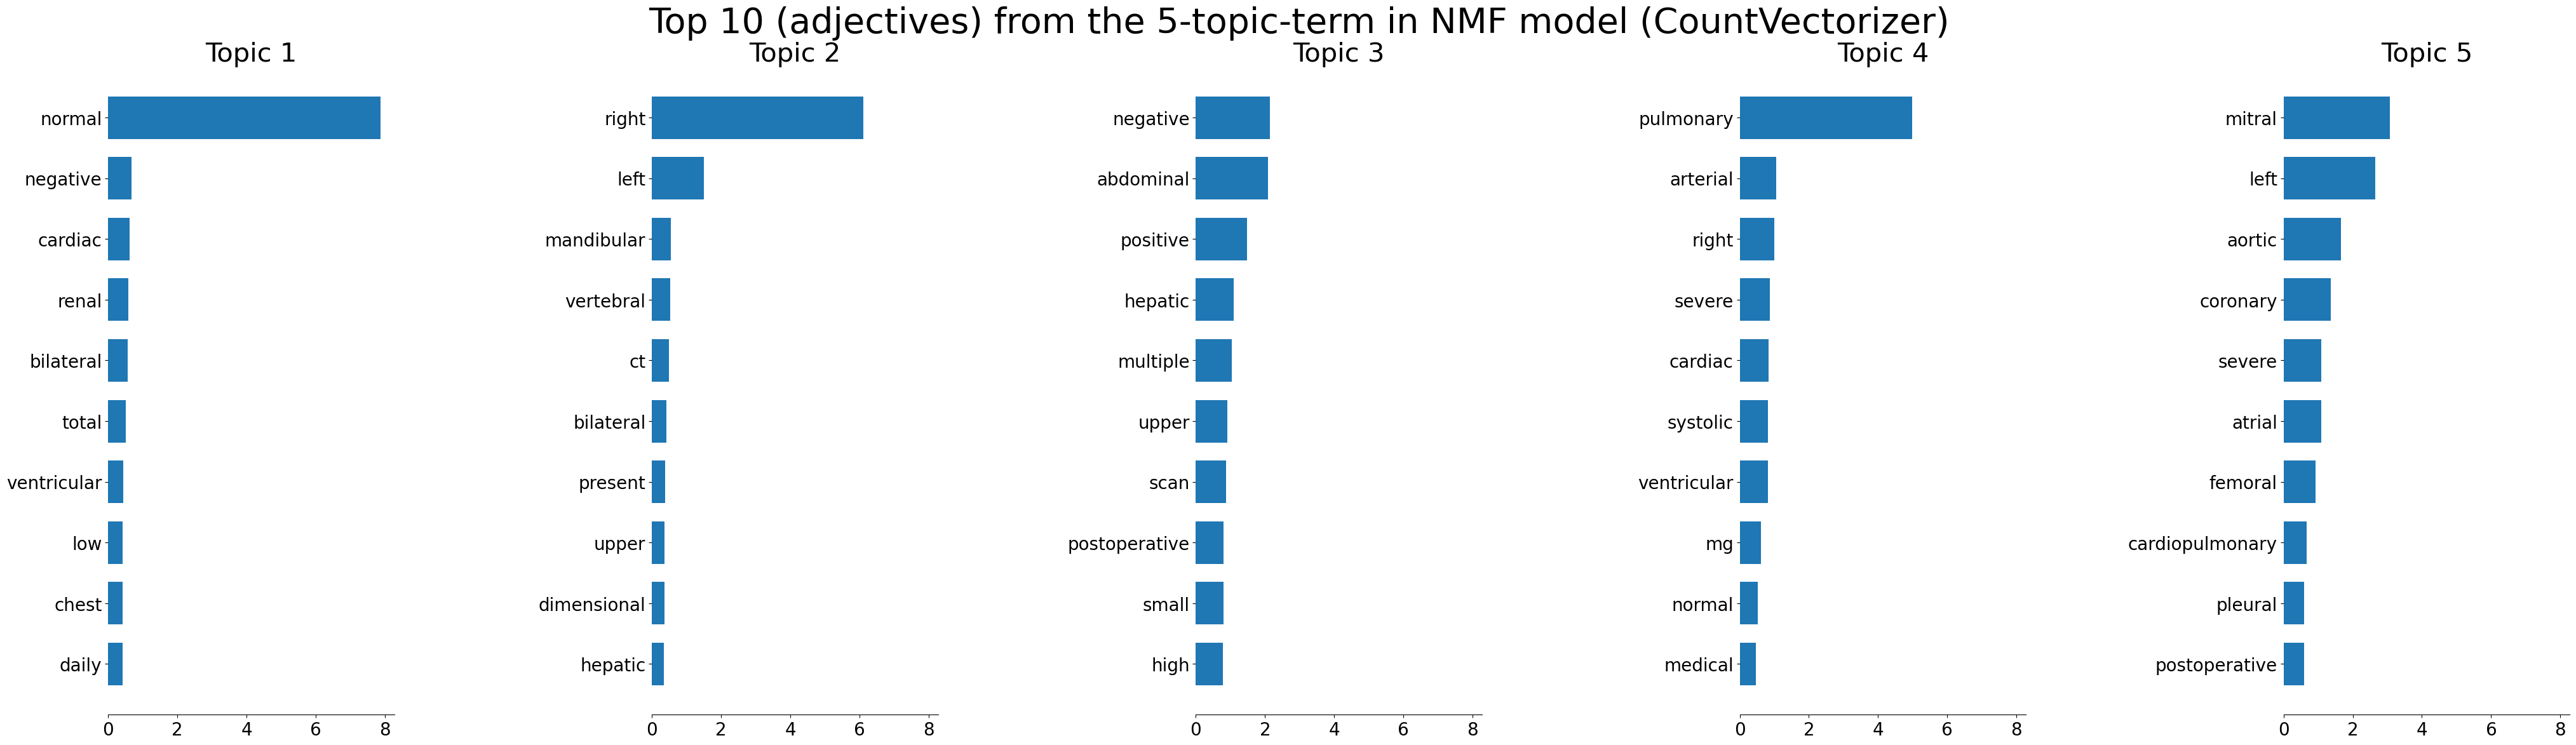

In [33]:
# TfidfVectorizer - NMF - adjectives
plot_top_words(model = nmf_model_adjective_tv,
               feature_names = tv_adjective.get_feature_names_out(),
               num_top_words = 10,
               title = 'Top 10-words (adjectives) from the 5-topic-term in NMF model (TfidfVectorizer)')

# CountVectorizer - NMF - adjectives
plot_top_words(model = nmf_model_adjective_cv,
               feature_names = cv_adjective.get_feature_names_out(),
               num_top_words = 10,
               title = 'Top 10 (adjectives) from the 5-topic-term in NMF model (CountVectorizer)')

### Final remarks

NMF transformed a group of *200* undifferentiated clinical case report documents into ones that can be summarised as a mix of topics which in turn are a mix of terms.  

The same parameters were used in TfidVectorizer and CounterVectorizer.


The verb category is not that informative for these analysis. I thought that the top 10 verbs in every topic will be related to the diagnosis, the disease or the treatment, but are more related with the verbs you normally use when writting and describing a clinical case. The adjectives, in other case, are informative and give us an idea of what the clinical cases are about.

When I compare the individual topic plots of every method I can notice that in most of the cases the top1 noun, adjective and verb when comparing between TfidVectorizer and CountVectorizer, is not the same, but 1 or 2 top1 terms are repeated between categories. When looking at the top10 words and comparing the topics of TfidVectorizer vs CountVectorizer some words are shared and some are not. 

TfidVectorizer in comparisson to CounterVectorizer.
**Tf** means **term-frequency** while **tf–idf** means **term-frequency times inverse document-frequency**. The TF-IDF scheme assigns weights to words based on how often they appear in a document relative to how often they appear in the entire corpus. The weights are floating point values. Whereas **CounterVectorizer** just takes into account how often they appear in a document.  
TF-IDF Vectorizer gives greater value to more unique terms than a CountVectorizer, so it will depend on the biological question that needs to be answered, the method that is going to be prefered.






### References
* https://towardsdatascience.com/nmf-a-visual-explainer-and-python-implementation-7ecdd73491f8 
* https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html
* https://scikit-learn.org/stable/modules/classes.html#text-feature-extraction-ref
* https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction 
* https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html
* https://towardsdatascience.com/basics-of-countvectorizer-e26677900f9c 